#**Generate DAG Image**

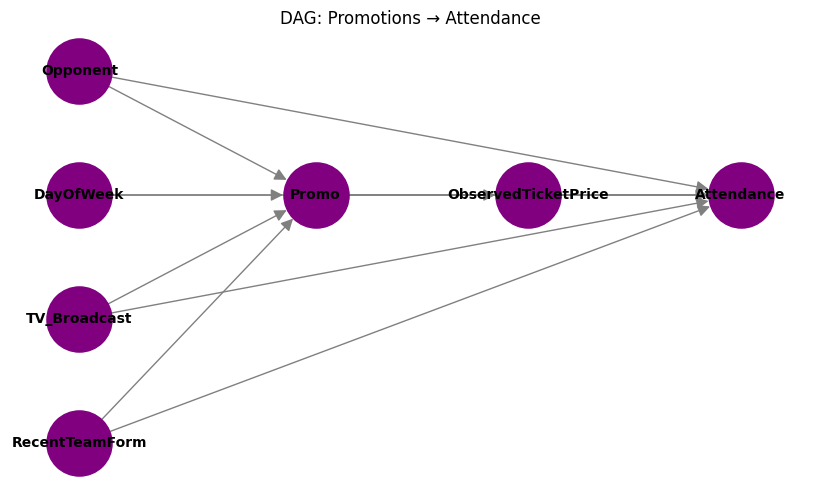

In [11]:
# simplified DAG image
import matplotlib.pyplot as plt
import networkx as nx

# define nodes
nodes = [
    "Promo", "Attendance",
    "Opponent", "DayOfWeek", "TV_Broadcast", "RecentTeamForm",
    "ObservedTicketPrice"
]

# define edges (simplified)
edges = [
    ("Promo", "Attendance"),
    ("Promo", "ObservedTicketPrice"),
    ("ObservedTicketPrice", "Attendance"),

    ("Opponent", "Promo"),
    ("Opponent", "Attendance"),

    ("DayOfWeek", "Promo"),
    ("DayOfWeek", "Attendance"),

    ("TV_Broadcast", "Promo"),
    ("TV_Broadcast", "Attendance"),

    ("RecentTeamForm", "Promo"),
    ("RecentTeamForm", "Attendance")
]

# create directed graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# layout - more compact
pos = {
    "Opponent": (-2, 1.5),
    "DayOfWeek": (-2, 0.5),
    "TV_Broadcast": (-2, -0.5),
    "RecentTeamForm": (-2, -1.5),

    "Promo": (0, 0.5),
    "ObservedTicketPrice": (1.8, 0.5),
    "Attendance": (3.6, 0.5)
}

plt.figure(figsize=(8, 4.5))
nx.draw(G, pos, with_labels=True, node_size=2200, node_color="purple",
        arrowsize=18, font_size=10, font_weight="bold", edge_color="gray")
plt.title("DAG: Promotions → Attendance", fontsize=12)
plt.axis('off')
plt.show()


#**Simulate Data**

In [12]:
import numpy as np
import polars as pl

# set randomization seed
rng = np.random.default_rng(42)

def sim_jazz_data(n=200,
                  beta_0=10000,
                  beta_price=-30,
                  beta_promo=500,
                  beta_opponent=1500,
                  beta_day=1200,
                  beta_tv=800,
                  beta_form=1000,
                  sigma=2000):
    """
    Simulates Jazz attendance data with causal structure:
    Promo → Attendance
    Promo → ObservedTicketPrice → Attendance
    Opponent, DayOfWeek, TV_Broadcast, RecentTeamForm → Promo and Attendance
    """

    # confounders
    opponent_strength = rng.normal(0, 1, size=n)  # z-score-ish
    day_of_week = rng.integers(0, 7, size=n)      # 0=Mon ... 6=Sun
    tv_broadcast = rng.binomial(1, 0.3, size=n)   # 30% of games on TV
    recent_form = rng.normal(0, 1, size=n)        # last 5 games performance index

    # promo assignment depends on confounders (not random!)
    promo_prob = 0.2 + 0.2*(opponent_strength < 0) + 0.1*(day_of_week < 5) + 0.1*(recent_form < 0) + 0.1*(tv_broadcast == 0)
    promo_prob = np.clip(promo_prob, 0.05, 0.9)
    promo = rng.binomial(1, promo_prob)

    # observed ticket price drops if promo is active
    base_price = rng.normal(60, 10, size=n)  # average base ticket
    observed_price = base_price - 15*promo   # promo discount

    # attendance model
    error = rng.normal(0, sigma, size=n)
    attendance = (beta_0
                  + beta_price*observed_price
                  + beta_promo*promo
                  + beta_opponent*opponent_strength
                  + beta_day*(day_of_week >= 5)  # weekends draw more
                  + beta_tv*tv_broadcast
                  + beta_form*recent_form
                  + error)

    # convert to dataframe
    data_df = pl.DataFrame({
        "Attendance": attendance,
        "Promo": promo,
        "ObservedTicketPrice": observed_price,
        "OpponentStrength": opponent_strength,
        "DayOfWeek": day_of_week,
        "TV_Broadcast": tv_broadcast,
        "RecentTeamForm": recent_form
    })

    return data_df

# simulate 200 games
df = sim_jazz_data(n=200)
df


Attendance,Promo,ObservedTicketPrice,OpponentStrength,DayOfWeek,TV_Broadcast,RecentTeamForm
f64,i64,f64,f64,i64,i64,f64
10962.092484,0,48.280284,0.304717,6,1,-0.170408
7359.330053,1,34.066761,-1.039984,0,0,-0.779482
8852.636827,0,62.889167,0.750451,1,0,0.430301
6539.606352,1,57.449474,0.940565,1,0,-0.851537
2981.18388,0,55.686606,-1.951035,1,0,0.665585
…,…,…,…,…,…,…
8578.057165,0,54.134149,-0.894727,0,0,0.816776
11873.42709,1,59.353002,0.643327,5,1,0.625085
12923.928724,1,47.437525,-0.394605,3,1,1.251725


#**Regression**

In [13]:
import pandas as pd

# attendance, opponent, hometeamperf, date, promo
df = pd.read_excel('/content/IS6950 data1.xlsx')
df.head()

,Date,Opponent,Result,Jazz W,Jazz L,Attend.,Promo,Opp W,Opp L,Avg Ticket Price,Revenue
0,Wed Oct 23 2024,Memphis Grizzlies,L,0,1,18175,1,1,0,81,1472175
1,Fri Oct 25 2024,Golden State Warriors,L,0,2,18175,1,2,0,81,1472175
2,Tue Oct 29 2024,Sacramento Kings,L,0,4,18175,0,2,2,81,1472175
3,Thu Oct 31 2024,San Antonio Spurs,L,0,5,18175,0,2,3,38,690650
4,Tue Nov 12 2024,Phoenix Suns,L,2,8,18175,1,9,2,87,1581225


In [14]:
# rename columns
df = df.rename(columns={
    "Date": "date",
    "Opponent": "opponent",
    "Result": "result",
    "Jazz W": "jazz_w",
    "Jazz L": "jazz_l",
    "Attend." : "attendance",
    "Promo": "promo",
    "Opp W": "opp_w",
    "Opp L ": "opp_l",
    "Avg Ticket Price": "avg_ticket",
    "Revenue": "revenue"
})

# convert date column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# convert date to numerical
df["date_num"] = df["date"].map(pd.Timestamp.toordinal)

# create binary weekend column
df['is_weekend'] = df['date'].dt.day_name().isin(["Friday", "Saturday", "Sunday"]).astype(int)

# assign each opponent an id
df["opponent_id"] = df["opponent"].astype("category").cat.codes

# calculate win percentages
df["jazz_win_pct"] = df["jazz_w"] / (df["jazz_w"] + df["jazz_l"])
df["opp_win_pct"] = df["opp_w"] / (df["opp_w"] + df["opp_l"])

# drop unnecessary columns
df = df.drop(['jazz_w', 'jazz_l', 'opp_w', 'opp_l', 'avg_ticket', 'attendance'], axis=1)

df.head()

,date,opponent,result,promo,revenue,date_num,is_weekend,opponent_id,jazz_win_pct,opp_win_pct
0,2024-10-23,Memphis Grizzlies,L,1,1472175,739182,0,14,0.0,1.000000
1,2024-10-25,Golden State Warriors,L,1,1472175,739184,1,9,0.0,1.000000
2,2024-10-29,Sacramento Kings,L,0,1472175,739188,0,25,0.0,0.500000
3,2024-10-31,San Antonio Spurs,L,0,690650,739190,0,26,0.0,0.400000
4,2024-11-12,Phoenix Suns,L,1,1581225,739202,0,23,0.2,0.818182


In [ ]:
!pip install bambi

In [24]:
import statsmodels.formula.api as smf
import bambi as bmb
import arviz as az

# bayes regression
ba_fit = bmb.Model(
  "revenue ~ promo + jazz_win_pct + opp_win_pct + is_weekend",
  data = df
).fit()

az.summary(ba_fit)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,774306.409,631139.396,-320965.348,2075680.638,17789.276,13557.172,1250.0,1078.0,1.0
is_weekend,249625.854,238581.290,-201666.224,692365.589,5297.672,5341.153,2026.0,1216.0,1.0
jazz_win_pct,2754398.110,1721318.422,-459626.322,5958894.415,50652.888,38574.031,1155.0,1125.0,1.0
opp_win_pct,616649.094,762836.191,-874560.996,1967196.503,18348.240,17120.606,1742.0,1164.0,1.0
promo,208539.469,290031.771,-342218.257,735383.136,6992.817,6546.809,1736.0,1366.0,1.0
sigma,708164.052,84779.443,560091.914,874862.848,1999.194,1963.112,1873.0,1337.0,1.0
